# Optimal Parameters for Stat model

In this notebook, I will try to find the optimal parameters to predict the amount of SHSAT applicants, based on the statistical distribution of grades.

## Prepare

First, I need to find a good distribution of grades for each school. We will use the Beta distribution, since it fits well and has bounds.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit, least_squares
from scipy.special import expit, logit
from scipy.stats import beta
from sklearn.metrics import r2_score

In [2]:
df = pd.read_pickle('../data/process/schools2017.pkl')
df = df[df['# SHSAT Testers'].notnull()]

# let's use Math scores only
mean_scores = df['Mean Scale Score - Math']

# % SHSAT Testers
percentage_shsat_testers = (df['# SHSAT Testers'] / df['# Students Grade 8']).values

# columns
columns = ['% Level 1 - Math', '% Level 2 - Math', '% Level 3 - Math', '% Level 4 - Math']
df = df[columns] / 100

df.head()

,% Level 1 - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math
DBN,,,,
01M034,0.519231,0.346154,0.134615,0.000000
01M140,0.473684,0.385965,0.140351,0.000000
01M184,0.096386,0.168675,0.289157,0.445783
01M301,0.487805,0.365854,0.121951,0.024390
01M332,0.576271,0.305085,0.084746,0.033898


In [3]:
# ranges retrieved from the NYS site
ranges = np.array([[160, 292], 
                   [293, 321], 
                   [322, 347], 
                   [348, 401]])

def scale(x):
    # scale grade [0, 1]
    return (x - ranges.min()) / (ranges.max() - ranges.min())

scaled_means = scale(mean_scores)
scaled_ranges = scale(ranges)

In [4]:
beta_a_list = []
beta_b_list = []

# calculate distribution parameters
for DBN, row in df.iterrows(): 
    # compute cdf
    xs = scaled_ranges[:, 1]
    ys = np.cumsum(row).values
    xs = np.insert(xs, 0, 0)
    ys = np.insert(ys, 0, 0)
    
    # estimate parameters
    mean = scaled_means.loc[DBN]
    def cdf(x, a):
        b = a / mean - a 
        return beta.cdf(x, a, b)
    popt, pcov = curve_fit(cdf, xs, ys)
    
    a = popt[0]
    b = a / mean - a
    
    # save results    
    beta_a_list.append(a)
    beta_b_list.append(b)

In [5]:
df['beta_a'] = beta_a_list
df['beta_b'] = beta_b_list

df.head()

,% Level 1 - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,beta_a,beta_b
DBN,,,,,,
01M034,0.519231,0.346154,0.134615,0.000000,7.107023,6.492796
01M140,0.473684,0.385965,0.140351,0.000000,10.409486,8.704954
01M184,0.096386,0.168675,0.289157,0.445783,7.314128,2.495091
01M301,0.487805,0.365854,0.121951,0.024390,7.264913,6.392738
01M332,0.576271,0.305085,0.084746,0.033898,5.617874,5.505999


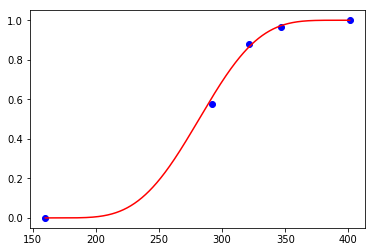

In [72]:
# check random entry (CDF)

sample = df.sample(1, random_state=1).iloc[0]
sample = df.iloc[4]

fig, ax = plt.subplots()

# plot real values
xs = ranges[:, 1]
xs = np.insert(xs, 0, ranges.min())
ys = sample.iloc[:4].values.cumsum()
ys = np.insert(ys, 0, 0)
ax.plot(xs, ys, 'bo')

# plot fitted curve
xs = np.linspace(ranges.min(), ranges.max(), 1000)
ys = beta.cdf(xs, sample.beta_a, sample.beta_b, loc=ranges.min(), scale=ranges.ptp())
ax.plot(xs, ys, 'r-');

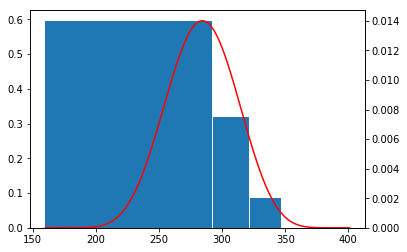

In [60]:
# check random entry (PDF)

sample = df.sample(1, random_state=1).iloc[0]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

xs = ranges.mean(axis=1)
widths = ranges.ptp(axis=1)
ys = sample.iloc[:4]
ax1.bar(xs, ys, width=widths)

xs = np.linspace(ranges.min(), ranges.max(), 1000)
ys = beta.pdf(xs, sample.beta_a, sample.beta_b, loc=ranges.min(), scale=ranges.ptp())
ax2.plot(xs, ys, color='red')

ax1.set_ylim(0, None)
ax2.set_ylim(0, None);

## Find optimal parameters

Here we will transform each distribution into an expected percentage of applicants. This function takes 2 parameters. We will use OLS (ordinary least squares) to optimize them.

In [73]:
# a and b are the parameters we want to find
# target is the logit of the percentage of appliers

def grade_to_target(grade, a, b):
    return a * grade + b
    
def expected_target(a, b, beta_a, beta_b):
    return beta.expect(lambda x: grade_to_target(x, a, b),
                       args=(beta_a, beta_b),
                       loc=ranges.min(),
                       scale=ranges.ptp())

# least squares
targets = logit(percentage_shsat_testers)
beta_parameters = df.iloc[:, -2:].values

def optfun(x):
    a = x[0]
    b = x[1]
    
    residuals = []
    for target, (beta_a, beta_b) in zip(targets, beta_parameters):
        residual = expected_target(a, b, beta_a, beta_b) - target
        residuals.append(residual)
    
    return np.array(residuals)        

result = least_squares(optfun, [1, 1], method='lm')

In [81]:
opt_a, opt_b = result.x

values = [expected_target(opt_a, opt_b, row.beta_a, row.beta_b) for _, row in df.iterrows()]
values = np.array(values)
values[:5]

array([-1.48486781, -1.29520656,  0.43761904, -1.40430121, -1.63615906])

R2 Score: 0.5378263998352187


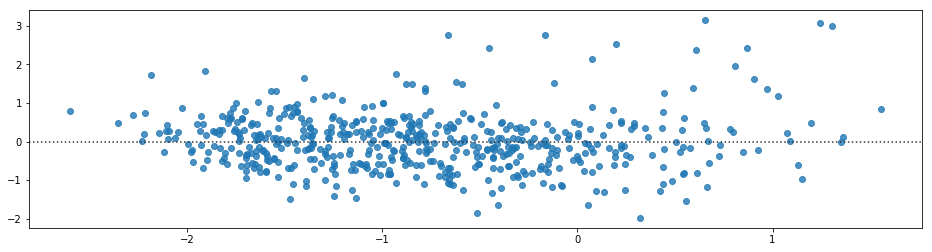

In [83]:
plt.figure(figsize=(16, 4))
sns.residplot(values, targets)
print("R2 Score:", r2_score(targets, values))

This values is worse than a model only using the mean of the grades. Is the model not good enough? Is it optimizing its parameters correctly?

We basked ourselves in lots of assumptions, and, maybe, these assumptions don't hold true. This may have broken our result.

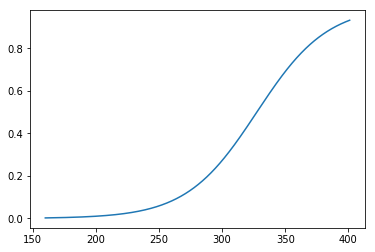

In [84]:
xs = np.linspace(ranges.min(), ranges.max(), 1000)
ys = expit(grade_to_target(xs, opt_a, opt_b))

plt.plot(xs, ys)

# this looks beliavable
# maybe if we combine this with the paper result...
# but the gains won't be too much though

# so, maybe, we are better off using the mean
# or using the test avalues from after the SHSAT